# full pipeline for a single subject, using 2-second segments

In [63]:
%matplotlib inline
import os
import glob
import seaborn
import numpy as np
import scipy as sp
import pandas as pd
import scipy.io
import numpy.fft
import scipy.signal
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import linregress
mpl.rcParams['figure.figsize'] = (16, 10)

In [125]:
def import_subject(import_path, subj):
    n = len(subj) # Number of subjects imported so far
    subj[n] = {}
    datafile = sp.io.loadmat(import_path)
    subj[n]['name'] = str(np.squeeze(datafile['name']))
    subj[n]['srate'] = int(np.squeeze(datafile['srate']))
    subj[n]['events'] = []
    for event in np.squeeze(datafile['evts']):
        # Events are organized like: [port_code, latency, event_num]
        subj[n]['events'].append([event[0][0], event[1][0][0], event[2][0][0]])
    subj[n]['data'] = np.squeeze(datafile['data'])
    return subj

In [126]:
subj = {}
subj = import_subject('../data/pipeline-full/oaExclFiltCARClust-mat/120127163.mat', subj)

In [160]:
def _print_window_info(events, port_code):
    evts = [[events[i][1], events[i+1][1]] for i in range(len(events)) if events[i][0] == port_code]
    total_wins = 0
    total_secs = 0
    for e in evts:
        if (e[1]-e[0]) >= 1024:
            pts  = e[1]-e[0]
            secs = (e[1]-e[0])//512
            nwin = (e[1]-e[0])//512-1
            total_wins += nwin
            total_secs += secs
            print('Event {}:\t{} points, {} seconds, {} windows'.format(e, pts, secs, nwin))
    print('Total windows able to be extracted: ', total_wins)
            
def get_windows(data, events, port_code, nperwindow=512*2, noverlap=512):
    windows = []
    # The following line restructures events of type port_code into the 
    # following format:
    #              [latency, end_of_event]
    evts = [[events[i][1], events[i+1][1]] for i in range(len(events)) if events[i][0] == port_code]
    for event in evts:
        if event[1]-event[0] >= nperwindow:
            nwindows = (event[1] - event[0])//noverlap - 1
            for i in range(nwindows):
                windows.append(data[event[0] + noverlap*i : event[0] + noverlap*i + nperwindow])
    return windows
    
def welch(windows, srate):
    """
    Takes a list of data segments (each size 1xN), computes each segment's PSD,
    and averages them to get a final PSD.
    """
    psds = [sp.signal.welch(window, srate, nperseg=len(window), window='hamming')[1] for window in windows]
    return np.mean(psds, axis=0)

In [161]:
_print_window_info(subj[0]['events'], 'C1')
_print_window_info(subj[0]['events'], 'O1')

Event [61346, 63527]:	2181 points, 4 seconds, 3 windows
Event [63886, 68222]:	4336 points, 8 seconds, 7 windows
Event [71011, 73525]:	2514 points, 4 seconds, 3 windows
Event [74211, 76079]:	1868 points, 3 seconds, 2 windows
Event [89880, 91917]:	2037 points, 3 seconds, 2 windows
Event [92767, 95333]:	2566 points, 5 seconds, 4 windows
Event [97828, 100571]:	2743 points, 5 seconds, 4 windows
Event [102830, 104567]:	1737 points, 3 seconds, 2 windows
Event [140797, 142567]:	1770 points, 3 seconds, 2 windows
Event [143142, 146701]:	3559 points, 6 seconds, 5 windows
Event [149568, 152558]:	2990 points, 5 seconds, 4 windows
Event [153382, 155393]:	2011 points, 3 seconds, 2 windows
Event [208861, 211741]:	2880 points, 5 seconds, 4 windows
Event [218011, 219872]:	1861 points, 3 seconds, 2 windows
Total windows able to be extracted:  46
Event [42721, 43956]:	1235 points, 2 seconds, 1 windows
Event [45158, 46366]:	1208 points, 2 seconds, 1 windows
Event [47913, 49409]:	1496 points, 2 seconds, 1 w

(0, 50)

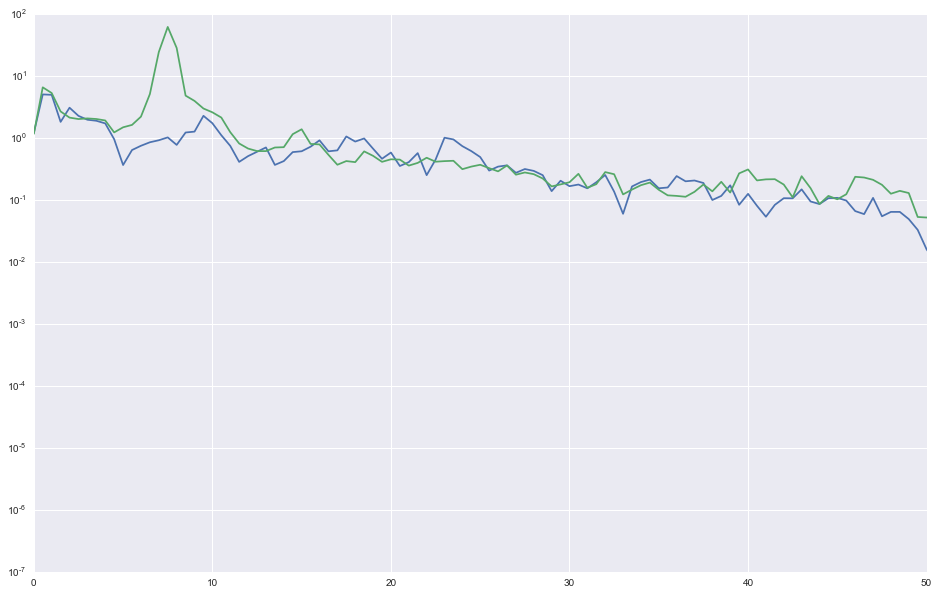

In [164]:
psdC = welch(get_windows(subj[0]['data'][10], subj[0]['events'], 'C1'), 512)
psdO = welch(get_windows(subj[0]['data'][10], subj[0]['events'], 'O1'), 512)
plt.semilogy(np.linspace(0, 256, len(psdC)), psdO, label='Eyes Open')
plt.semilogy(np.linspace(0, 256, len(psdC)), psdC, label='Eyes Closed')
plt.xlim([0, 50])

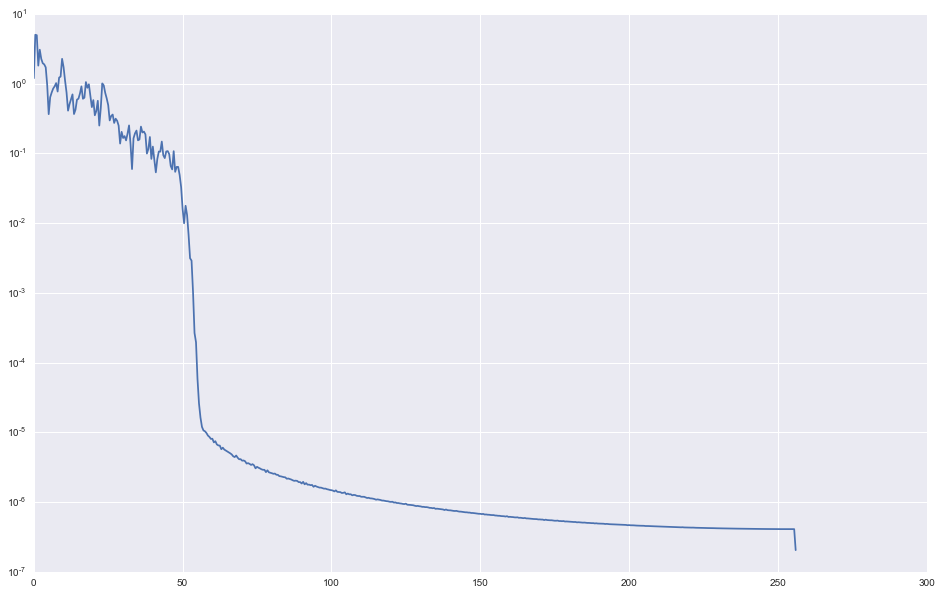

In [165]:
plt.semilogy(np.linspace(0, 256, len(psdC)), psdO)

(0, 50)

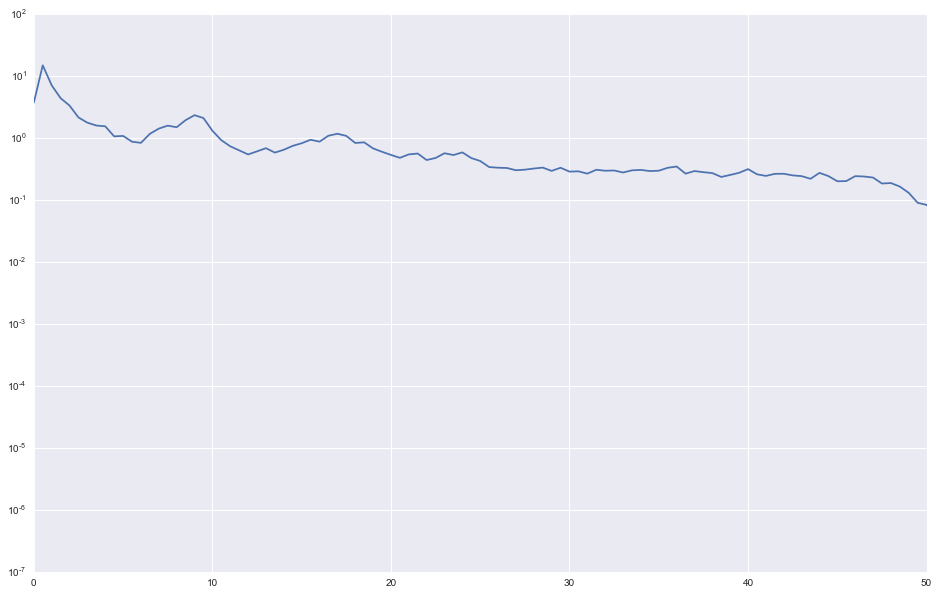

In [185]:
psd_list = []
for i in range(len(subj[0]['data'])):
    psd_list.append(welch(get_windows(subj[0]['data'][i], subj[0]['events'], 'O1'), 512))
grand_psd = np.mean(psd_list, axis=0)
plt.semilogy(np.linspace(0, 256, len(grand_psd)), grand_psd)
plt.xlim([0, 50])

(0, 50)

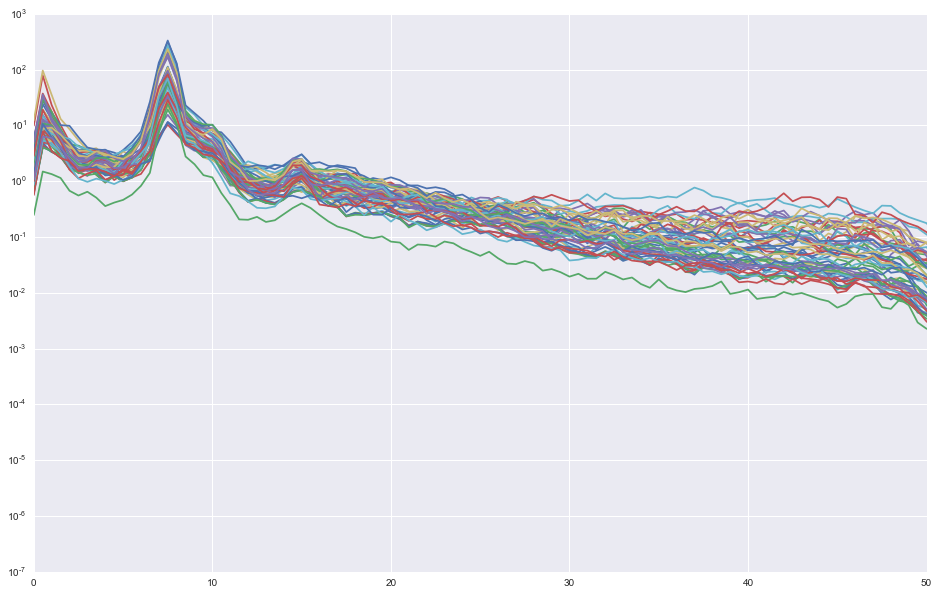

In [168]:
for i in range(len(subj[0]['data'])):
    psd = welch(get_windows(subj[0]['data'][i], subj[0]['events'], 'C1'), 512)
    plt.semilogy(np.linspace(0, 256, len(psd)), psd)
plt.xlim([0, 50])

The eyes-open PSD for this subject doesn't look so great. Let's see if importing a younger adult provides smoother PSDs:

In [181]:
subj = import_subject('../data/pipeline-full/yaExclFiltCARClust-mat/112118723.mat', subj)
subj[1]['data'][51] = subj[1]['data'][50]

(0, 50)

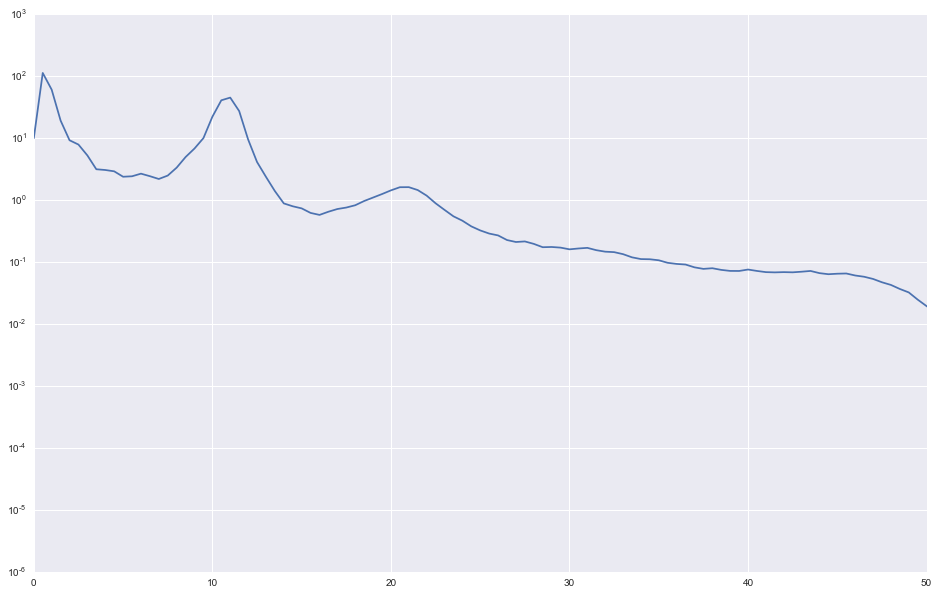

In [184]:
psd_list = []
for i in range(len(subj[1]['data'])):
    psd_list.append(welch(get_windows(subj[1]['data'][i], subj[1]['events'], 'C1'), 512))
grand_psd = np.mean(psd_list, axis=0)
plt.semilogy(np.linspace(0, 256, len(grand_psd)), grand_psd)
plt.xlim([0, 50])

(0, 50)

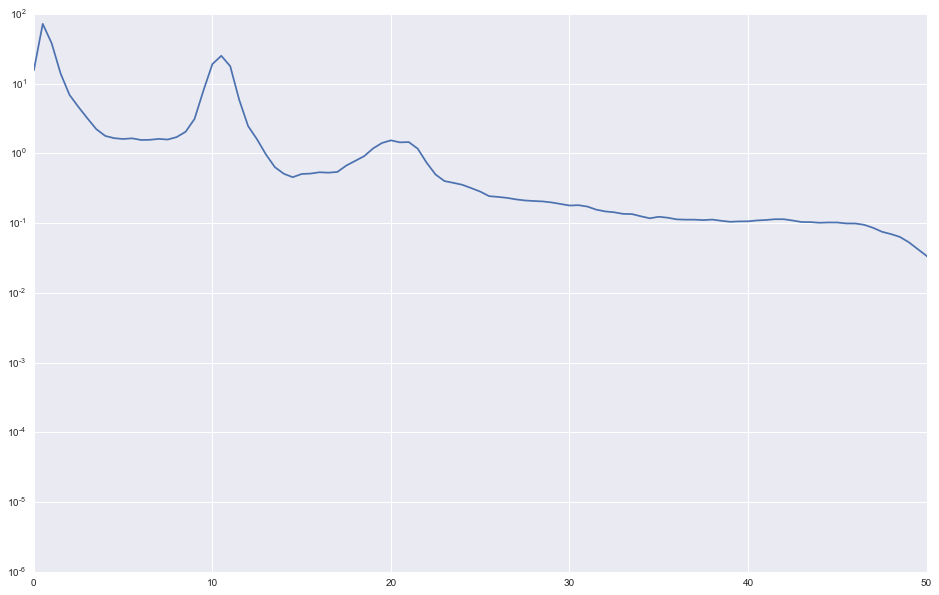

In [186]:
psd_list = []
for i in range(len(subj[1]['data'])):
    psd_list.append(welch(get_windows(subj[1]['data'][i], subj[1]['events'], 'O1'), 512))
grand_psd = np.mean(psd_list, axis=0)
plt.semilogy(np.linspace(0, 256, len(grand_psd)), grand_psd)
plt.xlim([0, 50])

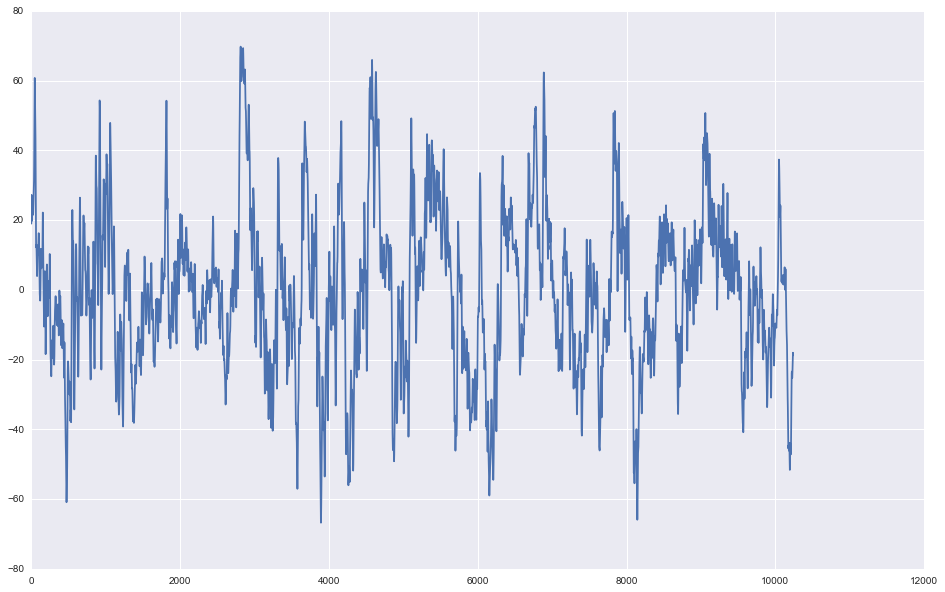

In [180]:
plt.plot(subj[1]['data'][51][0:512*20])

In [187]:
len(grand_psd)

513